In [1]:
# libraries import
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import seaborn as sns

In [46]:
#initial structures load
initials = pd.read_excel('../Data/Kolchicyna_prepared_data.xlsx')
initials['Initial/new'] = 'Initial'

In [47]:
new_structures = pd.read_excel('../Data/Proposed_structures_with_AI_colchicyne_tanimoto_similarity_.xlsx')
new_structures['Initial/new'] = 'New'
new_structures = new_structures.rename(columns={"AI_generated_SMILES" : "SMILES"})

In [48]:
whole_df = initials[['SMILES', 'Initial/new']]
whole_df = whole_df.append(new_structures[['SMILES', 'Initial/new']])

In [49]:
whole_df.head()

,SMILES,Initial/new
0,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial
1,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial
2,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial
3,CC(C)CN[C@H]2CCc3cc(OC)c(OC)c(OC)c3C1=CC=C(SC)...,Initial
4,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial


In [50]:
# Molecular fingerprints calculations
class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

In [51]:
def fingerprint(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    arr = np.zeros((1,), dtype)
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

In [52]:
# Molecular fingerprints calculations
whole_df['FP'] = [fingerprint(Chem.MolFromSmiles(smi)) for smi in whole_df['SMILES']]

In [53]:
data_ = np.array([x.fp for x in whole_df['FP']])

In [54]:
# t-SNE analysis
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_whole_set = model.fit_transform(data_)

In [55]:
whole_df['TSNE_C1'] = tsne_whole_set.T[0]
whole_df['TSNE_C2'] = tsne_whole_set.T[1]

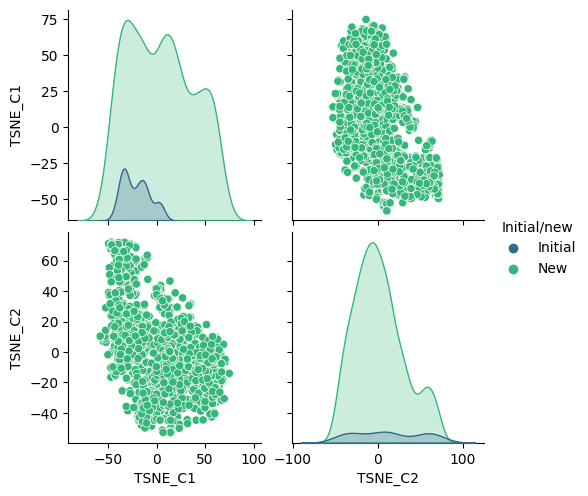

In [56]:
# t-SNE plot
sns.pairplot(whole_df, hue='Initial/new', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

In [57]:
x_t = whole_df.loc[whole_df['Initial/new'] == 'Initial']
len(x_t)

120

In [58]:
x_r = whole_df.loc[whole_df['Initial/new'] == 'New']
len(x_r)

1356

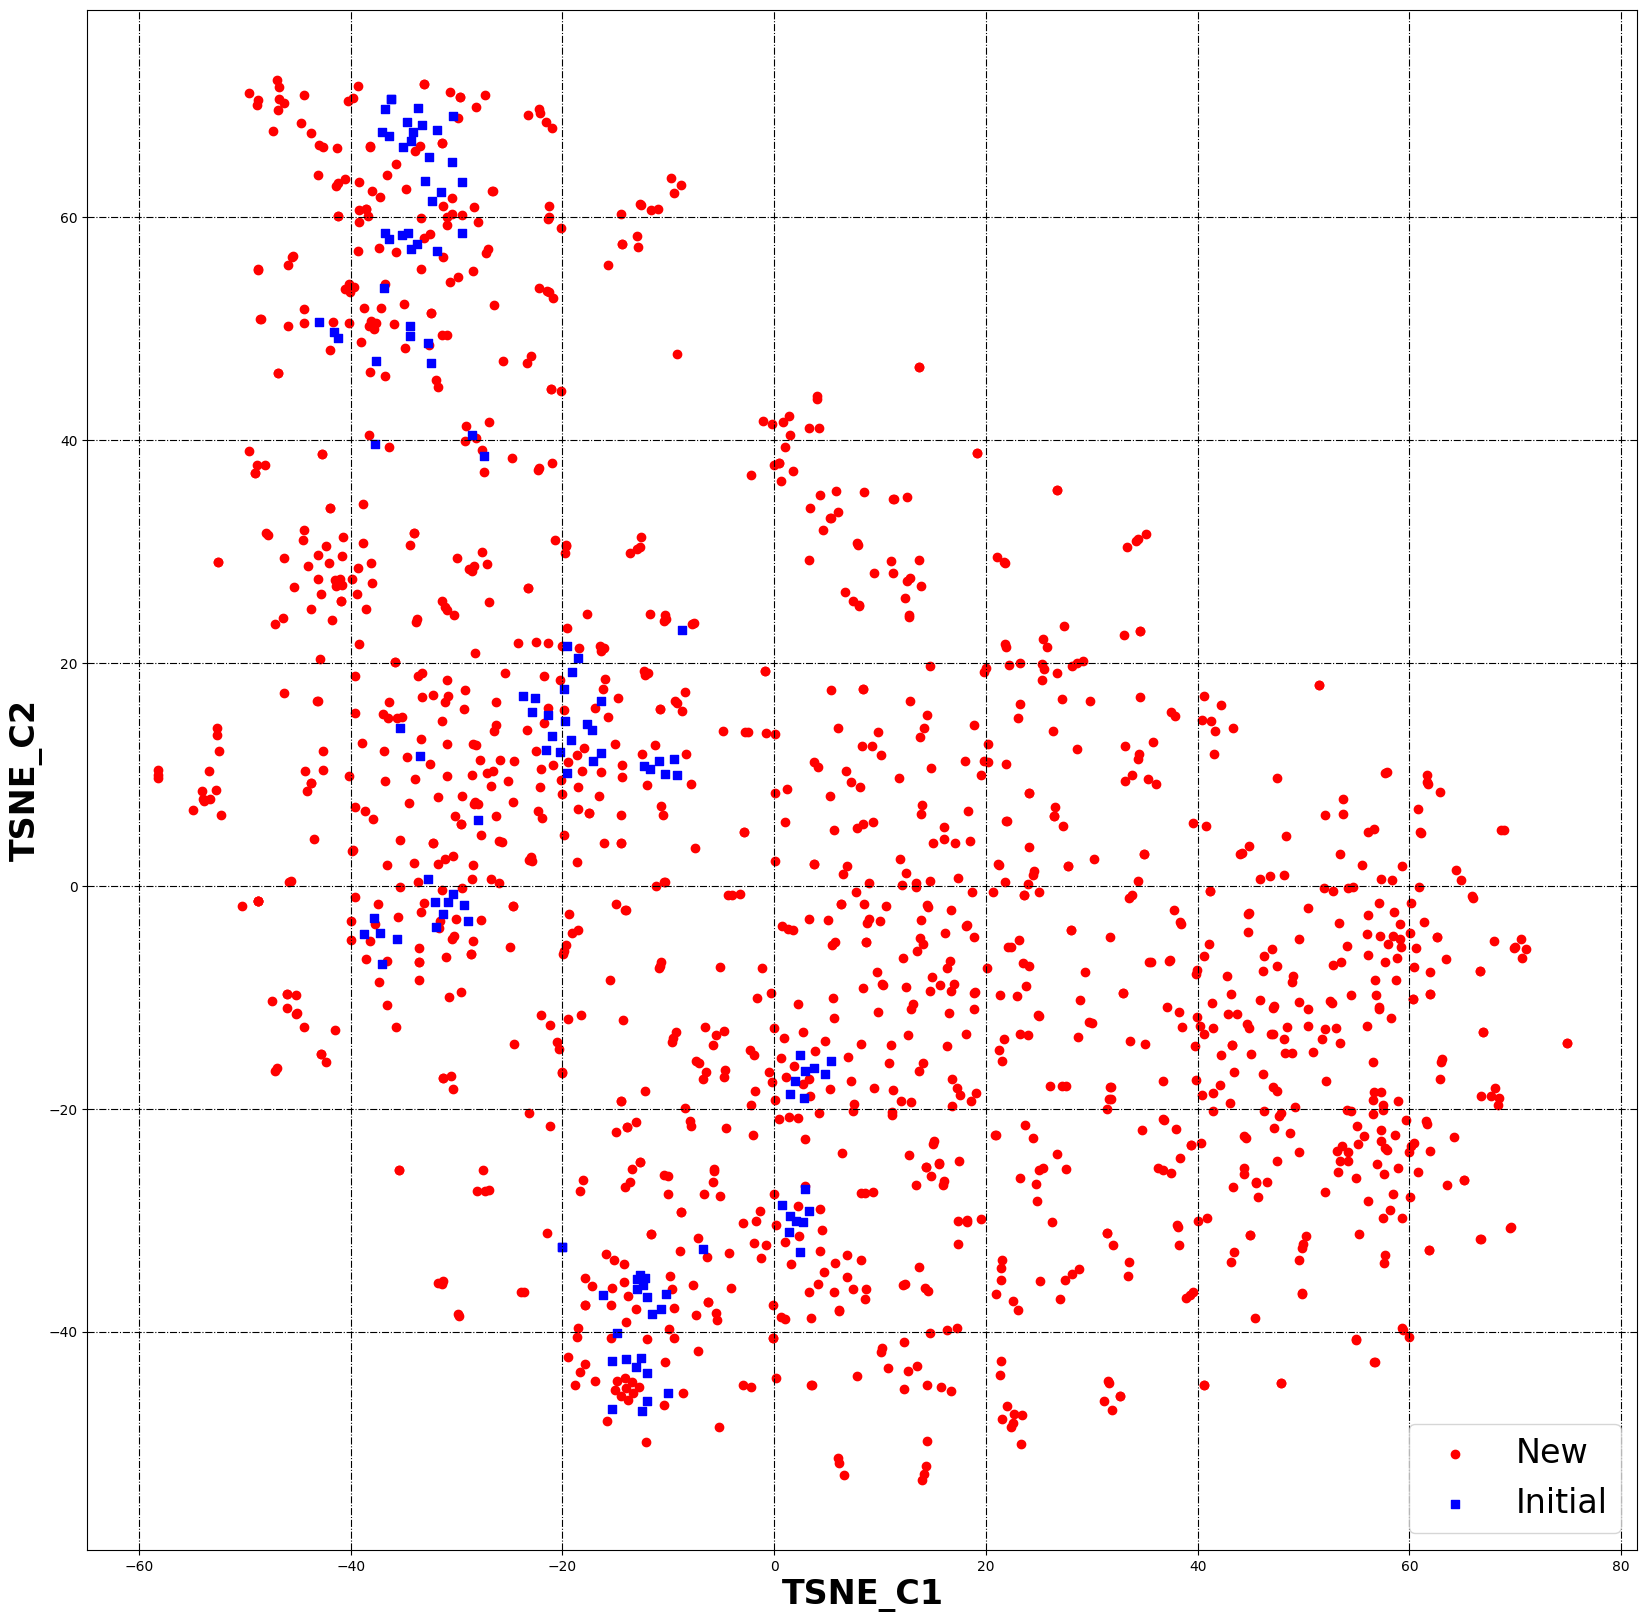

In [59]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.scatter(x_r['TSNE_C1'], x_r['TSNE_C2'], c='r', marker="o", label='New') #, alpha=1
ax.scatter(x_t['TSNE_C1'], x_t['TSNE_C2'], c='b', marker="s", label='Initial')#, alpha=0.1
plt.legend(loc='lower right', fontsize=24)
plt.xlabel('TSNE_C1', fontweight='bold', fontsize=24)
plt.ylabel('TSNE_C2', fontweight='bold', fontsize=24)
plt.rc('grid', linestyle="-.", color='black')
plt.grid(True)
plt.savefig('t-SNE_analysis_all_generated_no_PCA.pdf', bbox_inches='tight')
plt.show()

In [16]:
# PCA analysis
pca = PCA(n_components=5, random_state=42) #n_components=20 in the case of activity_pred_app
pca_training_whole = pca.fit_transform(data_)

In [17]:
list_pca = []
for i in range(5):
    list_pca.append('PC'+str(i+1))

In [18]:
for pca_ in range(5):
    whole_df[list_pca[pca_]] = pca_training_whole.T[pca_]

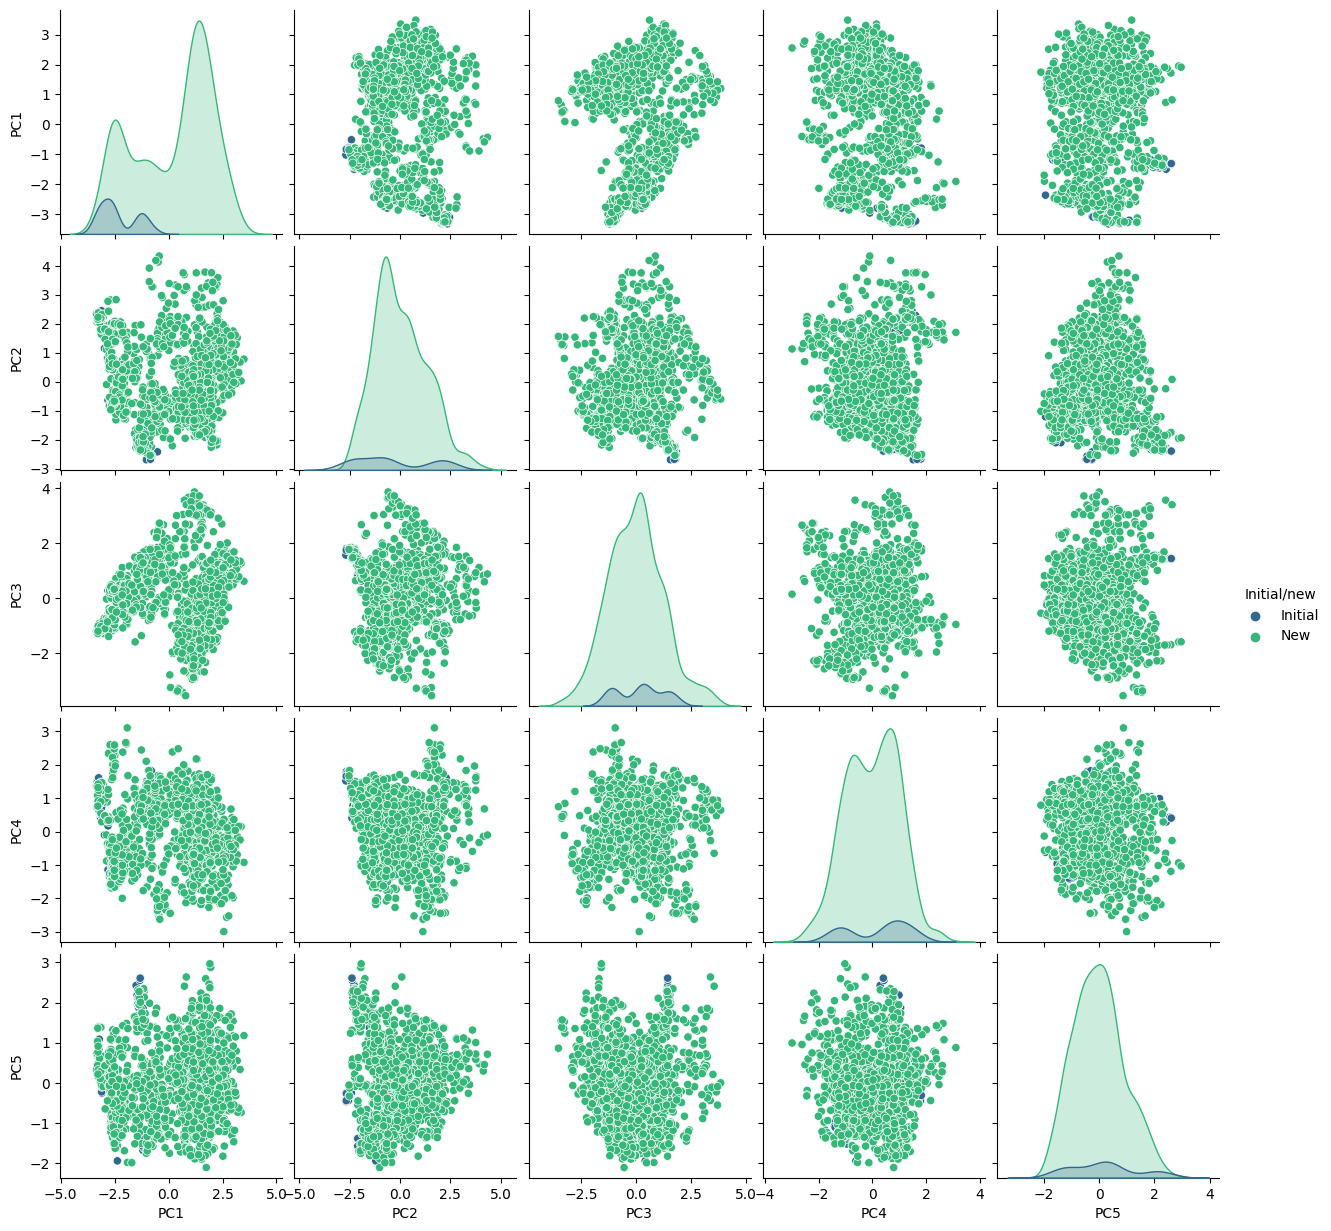

In [19]:
sns.pairplot(whole_df, hue='Initial/new', vars=list_pca, palette='viridis')

In [20]:
# t-SNE analysis
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_whole_set = model.fit_transform(pca_training_whole)

In [21]:
whole_df['TSNE_C1'] = tsne_whole_set.T[0]
whole_df['TSNE_C2'] = tsne_whole_set.T[1]

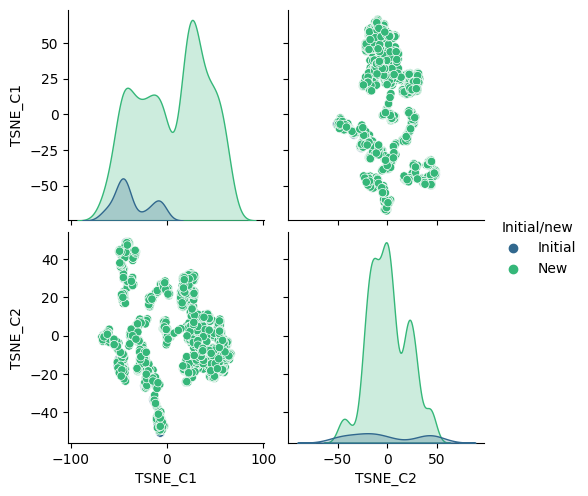

In [22]:
# t-SNE plot
sns.pairplot(whole_df, hue='Initial/new', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

In [23]:
x_t = whole_df.loc[whole_df['Initial/new'] == 'Initial']
print(len(x_t))
x_r = whole_df.loc[whole_df['Initial/new'] == 'New']
len(x_r)

120


1356

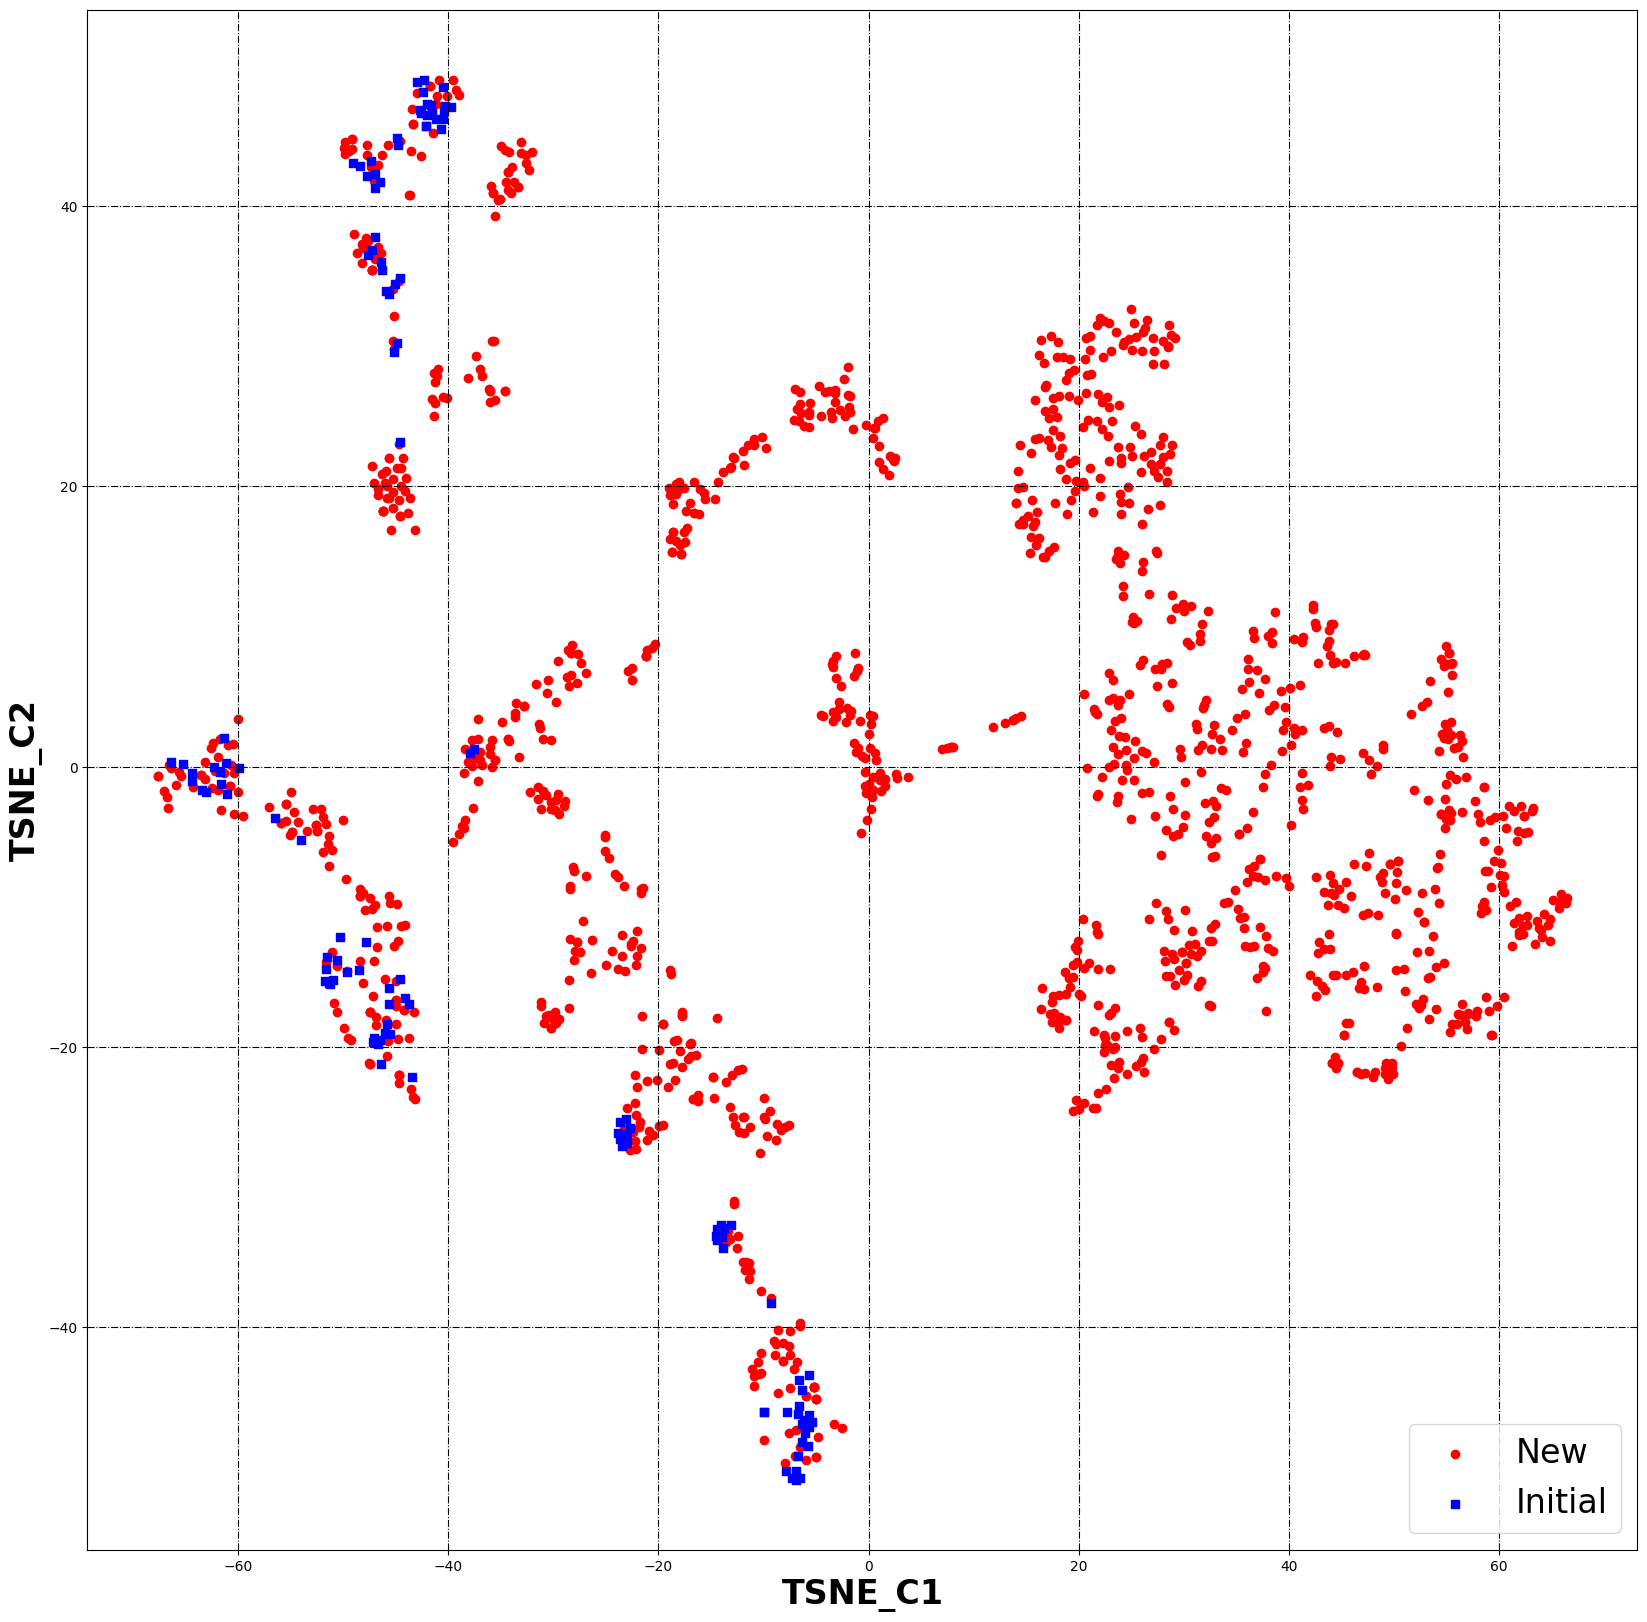

In [24]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.scatter(x_r['TSNE_C1'], x_r['TSNE_C2'], c='r', marker="o", label='New') #, alpha=1
ax.scatter(x_t['TSNE_C1'], x_t['TSNE_C2'], c='b', marker="s", label='Initial')#, alpha=0.1
plt.legend(loc='lower right', fontsize=24)
plt.xlabel('TSNE_C1', fontweight='bold', fontsize=24)
plt.ylabel('TSNE_C2', fontweight='bold', fontsize=24)
plt.rc('grid', linestyle="-.", color='black')
plt.grid(True)
plt.savefig('t-SNE_analysis_all_generated.pdf', bbox_inches='tight')
plt.show()

## Only structures that are selected

In [25]:
new_structures = pd.read_excel('../Data/Whole_report.xlsx')
new_structures['Initial/new'] = 'New'

In [26]:
whole_df_ = initials[['SMILES', 'Initial/new']]
whole_df_ = whole_df_.append(new_structures[['SMILES', 'Initial/new']])

In [27]:
# Molecular fingerprints calculations
whole_df_['FP'] = [fingerprint(Chem.MolFromSmiles(smi)) for smi in whole_df_['SMILES']]

In [28]:
data_ = np.array([x.fp for x in whole_df_['FP']])

In [29]:
# t-SNE analysis
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_whole_set = model.fit_transform(data_)

In [30]:
whole_df_['TSNE_C1'] = tsne_whole_set.T[0]
whole_df_['TSNE_C2'] = tsne_whole_set.T[1]

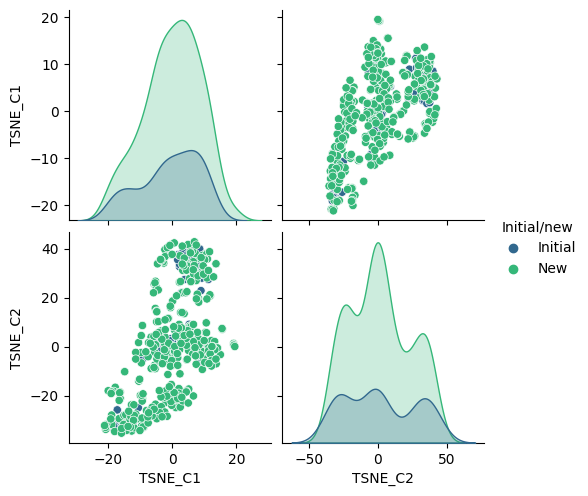

In [31]:
# t-SNE plot
sns.pairplot(whole_df_, hue='Initial/new', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

In [32]:
x_t = whole_df_.loc[whole_df_['Initial/new'] == 'Initial']
len(x_t)

120

In [33]:
x_r = whole_df_.loc[whole_df_['Initial/new'] == 'New']
len(x_r)

335

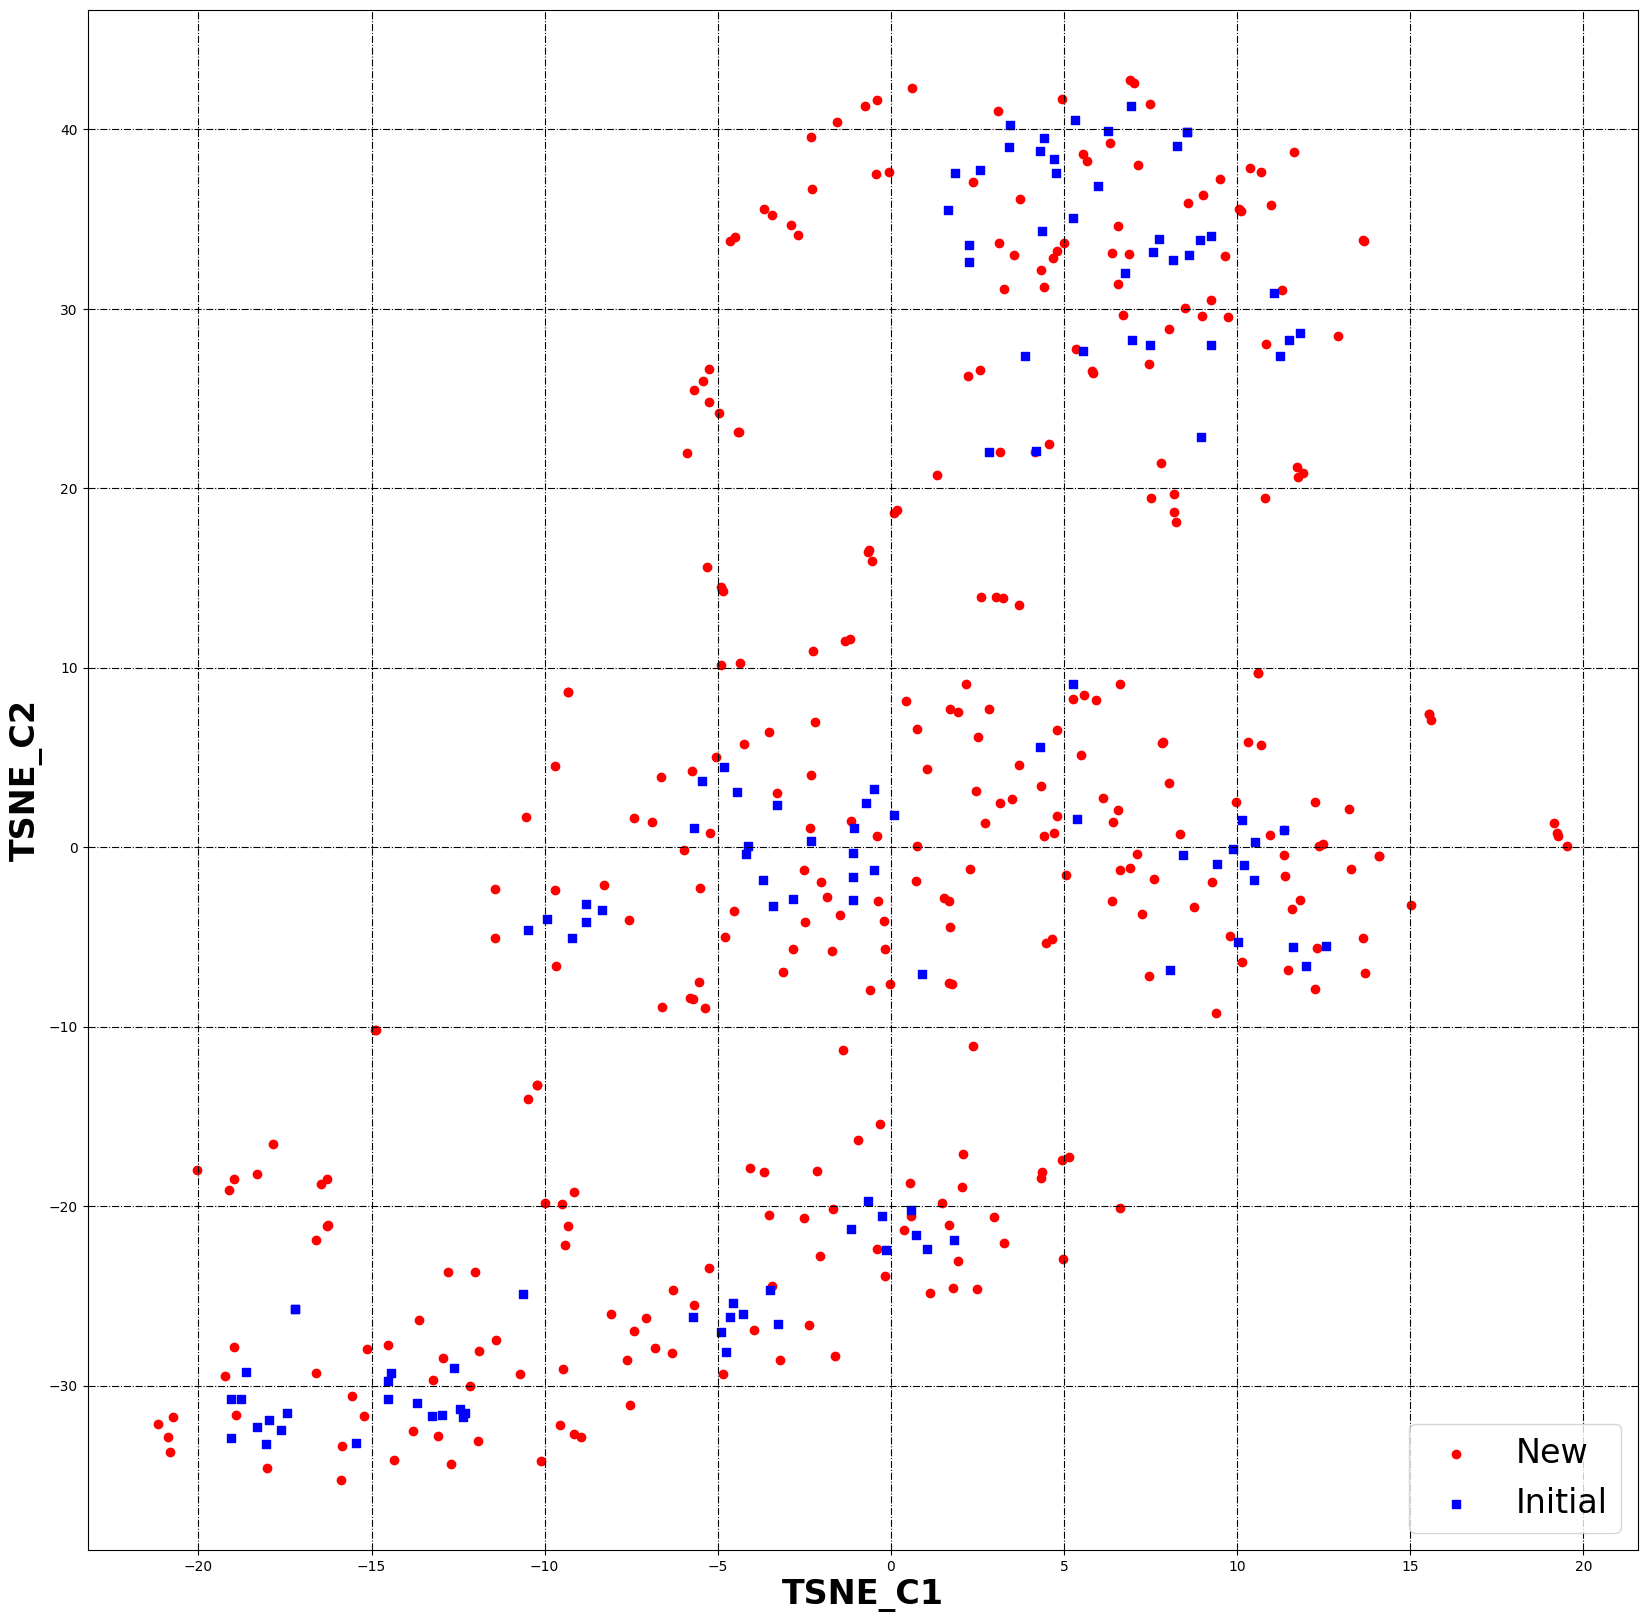

In [34]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.scatter(x_r['TSNE_C1'], x_r['TSNE_C2'], c='r', marker="o", label='New') #, alpha=1
ax.scatter(x_t['TSNE_C1'], x_t['TSNE_C2'], c='b', marker="s", label='Initial')#, alpha=0.1
plt.legend(loc='lower right', fontsize=24)
plt.xlabel('TSNE_C1', fontweight='bold', fontsize=24)
plt.ylabel('TSNE_C2', fontweight='bold', fontsize=24)
plt.rc('grid', linestyle="-.", color='black')
plt.grid(True)
plt.savefig('t-SNE_analysis_selected_generated_PCA_2.pdf', bbox_inches='tight')
plt.show()

In [35]:
# PCA analysis
pca = PCA(n_components=5, random_state=42) #n_components=20 in the case of activity_pred_app
pca_training_whole = pca.fit_transform(data_)

In [36]:
list_pca = []
for i in range(5):
    list_pca.append('PC'+str(i+1))

In [37]:
for pca_ in range(5):
    whole_df_[list_pca[pca_]] = pca_training_whole.T[pca_]

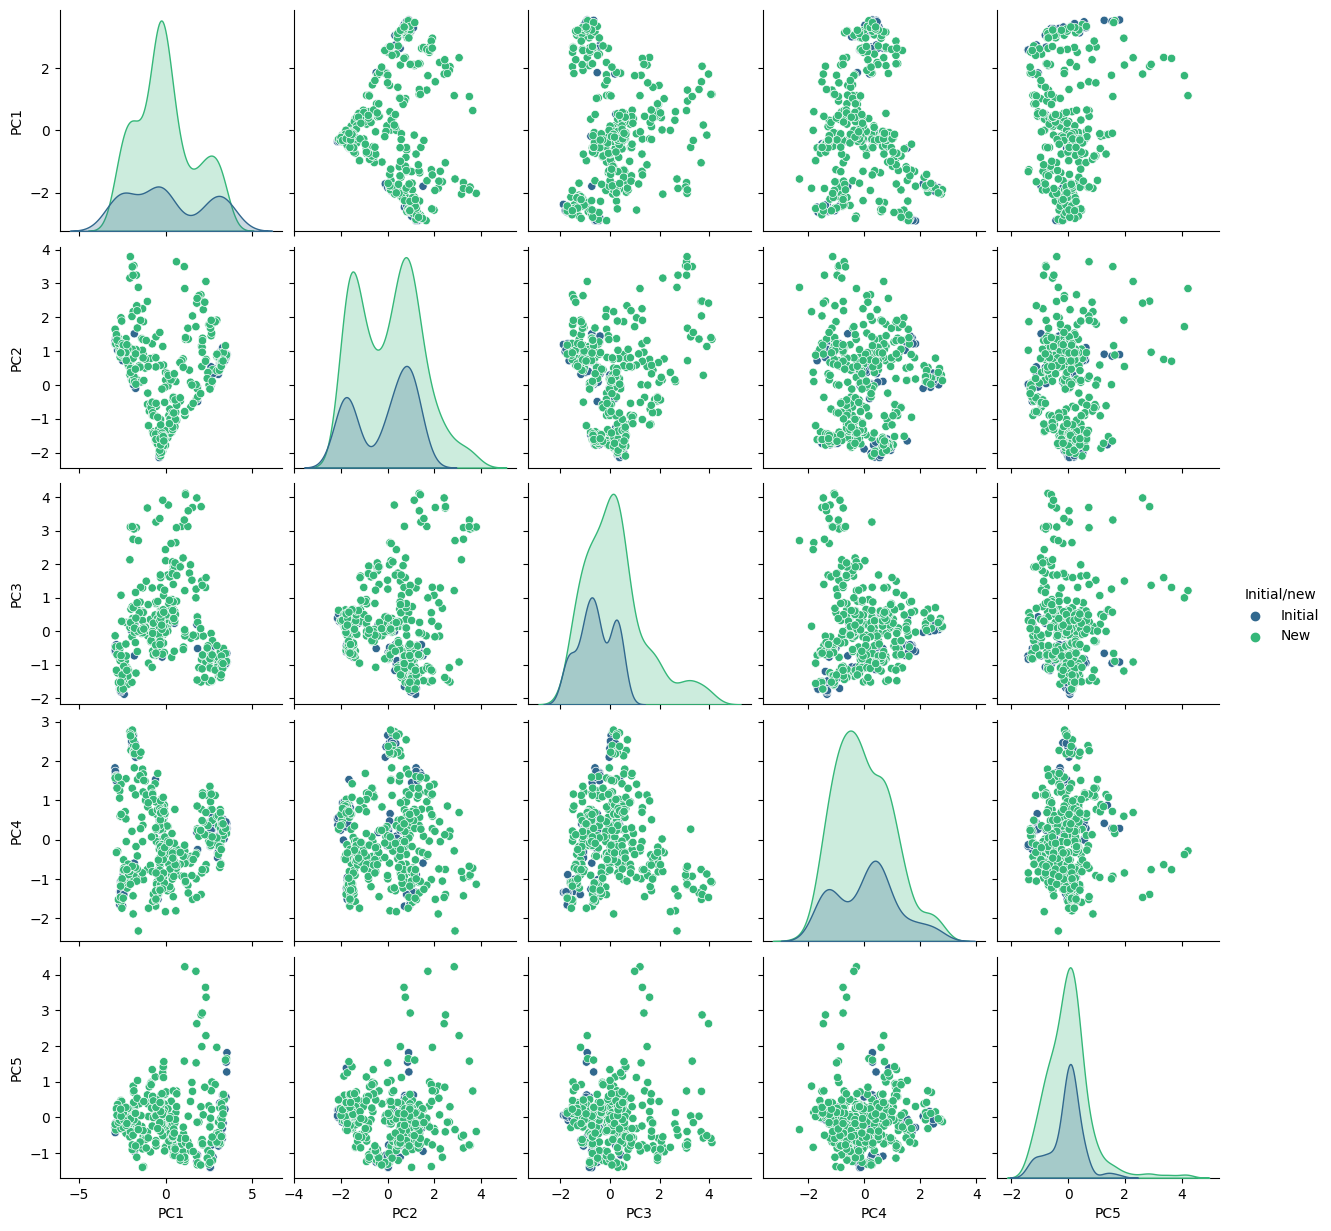

In [38]:
sns.pairplot(whole_df_, hue='Initial/new', vars=list_pca, palette='viridis')

In [39]:
# t-SNE analysis
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_whole_set = model.fit_transform(pca_training_whole)

In [40]:
whole_df_['TSNE_C1'] = tsne_whole_set.T[0]
whole_df_['TSNE_C2'] = tsne_whole_set.T[1]

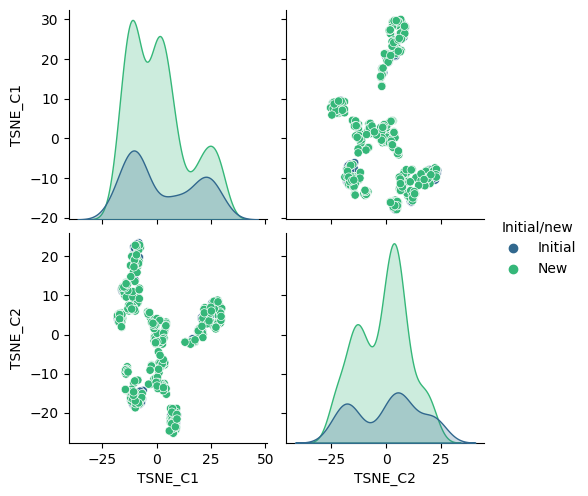

In [41]:
# t-SNE plot
sns.pairplot(whole_df_, hue='Initial/new', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

In [42]:
x_t = whole_df_.loc[whole_df_['Initial/new'] == 'Initial']
print(len(x_t))
x_r = whole_df_.loc[whole_df_['Initial/new'] == 'New']
len(x_r)

120


335

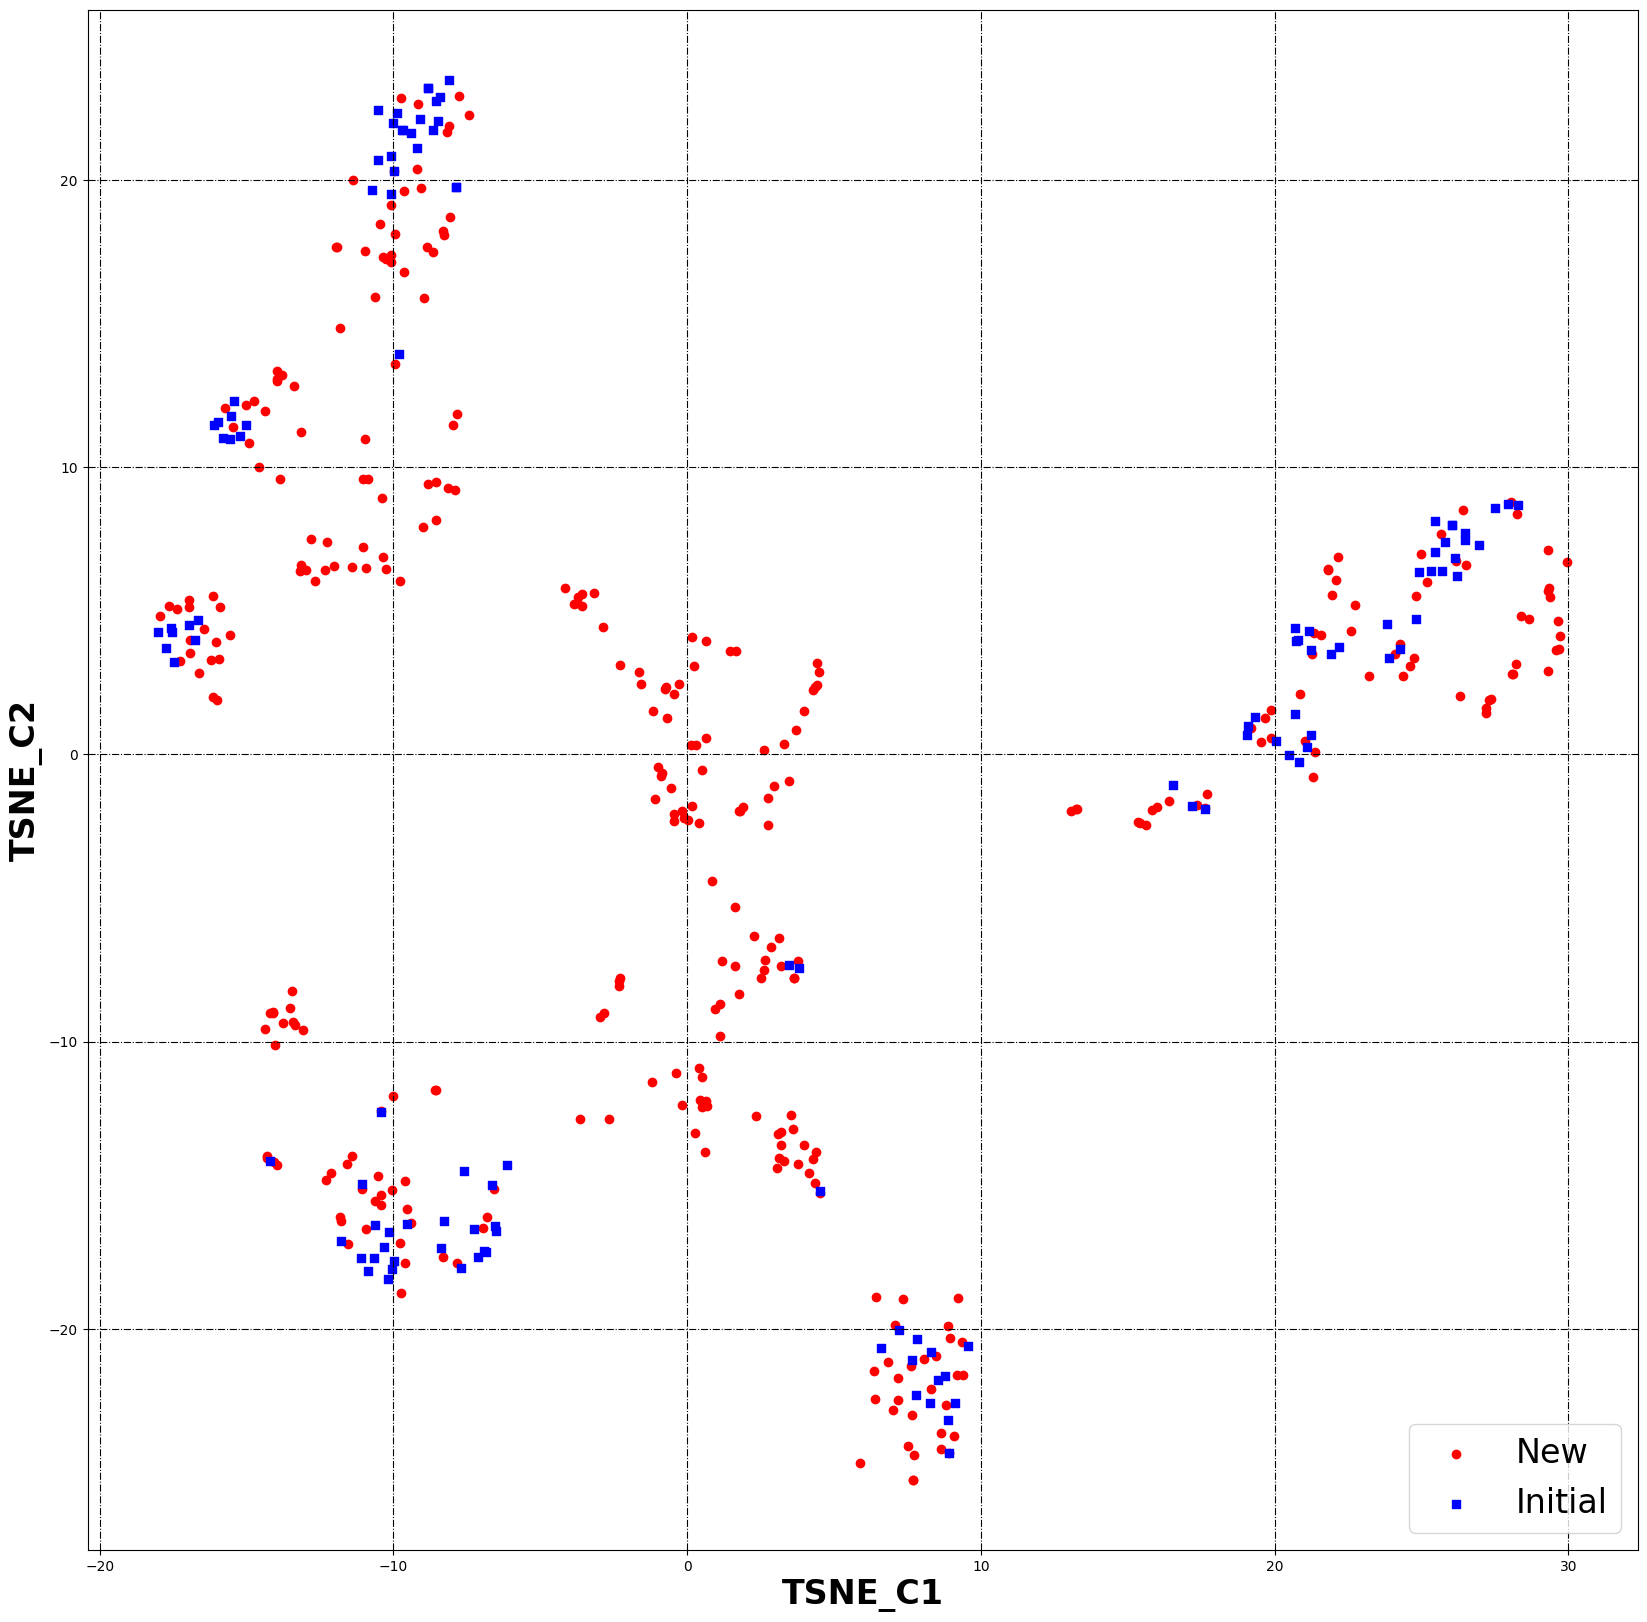

In [43]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.scatter(x_r['TSNE_C1'], x_r['TSNE_C2'], c='r', marker="o", label='New') #, alpha=1
ax.scatter(x_t['TSNE_C1'], x_t['TSNE_C2'], c='b', marker="s", label='Initial')#, alpha=0.1
plt.legend(loc='lower right', fontsize=24)
plt.xlabel('TSNE_C1', fontweight='bold', fontsize=24)
plt.ylabel('TSNE_C2', fontweight='bold', fontsize=24)
plt.rc('grid', linestyle="-.", color='black')
plt.grid(True)
plt.savefig('t-SNE_analysis_all_generated_PCA_5.pdf', bbox_inches='tight')
plt.show()

In [44]:
whole_df_.head()

,SMILES,Initial/new,FP,TSNE_C1,TSNE_C2,PC1,PC2,PC3,PC4,PC5
0,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial,1024 bit FP,-10.516629,20.702110,-2.562503,0.952497,-1.505651,-1.099564,-0.178360
1,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial,1024 bit FP,-9.104795,22.109497,-2.609674,0.952670,-1.650509,-1.440522,0.029450
2,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial,1024 bit FP,-8.091981,23.488331,-2.470824,0.717305,-1.650362,-1.689266,0.085596
3,CC(C)CN[C@H]2CCc3cc(OC)c(OC)c(OC)c3C1=CC=C(SC)...,Initial,1024 bit FP,-10.093107,20.833193,-2.575260,1.009453,-1.548183,-1.154107,-0.071839
4,COc2c3C1=CC=C(SC)C(=O)C=C1[C@H](CCc3cc(OC)c2OC...,Initial,1024 bit FP,-8.543242,22.754614,-2.625635,0.947688,-1.711178,-1.624480,0.108450


In [45]:
len(whole_df_)

455